In [51]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import json

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
DEVICE = 'cpu'
from sklearn import metrics

In [2]:
with open("../data/synthetic_data/large_synthetic_data_aggregate.json") as f:
    data = json.load(f)

In [3]:
all_sequence_lens = []
all_annotations = []

human_to_trial_num_to_sequence = {}
min_len_seq = 0
max_len_seq = 0

for case_id in data:
    human_id = int(case_id.split(".")[0])
    trial_id = 1
#     trial_id = int(case_id.split(".")[1])
    
    if human_id not in human_to_trial_num_to_sequence:
        human_to_trial_num_to_sequence[human_id] = {}
        
    human_to_trial_num_to_sequence[human_id][trial_id] = data[case_id]
    
    for elem in data[case_id]:
        if elem not in all_annotations:
            all_annotations.append(elem)
            
    all_sequence_lens.append(len(data[case_id]))
    
    

In [4]:
max(all_sequence_lens)

19

In [5]:
num_to_annot = dict(enumerate(all_annotations))
annot_to_num = {v: k for k, v in num_to_annot.items()}
number_of_annots = len(all_annotations)

In [6]:
len(human_to_trial_num_to_sequence)

100000

In [7]:
human_to_trial_num_to_traj = {}

for human_id in range(100):
    human_to_trial_num_to_traj[human_id] = {}
    for trial_id in human_to_trial_num_to_sequence[human_id]:
        human_to_trial_num_to_traj[human_id][trial_id] = []
        
        current_state = np.zeros(number_of_annots)
        seq = human_to_trial_num_to_sequence[human_id][trial_id]
        
        for i in range(len(seq)):
            annot_idx = annot_to_num[seq[i]]
            current_state[annot_idx] = current_state[annot_idx] + 1
            
            normalized_current_state = [elem/sum(current_state) for elem in current_state]
            
            human_to_trial_num_to_traj[human_id][trial_id].extend(normalized_current_state)
            
        for i in range(len(seq), max(all_sequence_lens)):
            annot_idx = annot_to_num['end']
            current_state[annot_idx] = current_state[annot_idx] + 1
            
#             human_to_trial_num_to_traj[human_id][trial_id].extend(current_state)
            
            normalized_current_state = [elem/sum(current_state) for elem in current_state]
            
            human_to_trial_num_to_traj[human_id][trial_id].extend(normalized_current_state)
        
    
    

# Create AE

In [8]:
class Autoenc(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
         torch.nn.Linear(361, 64),
         torch.nn.ReLU(),
#          torch.nn.Linear(128, 64),
#          torch.nn.ReLU(),
         torch.nn.Linear(64, 36),
         torch.nn.ReLU(),
         torch.nn.Linear(36, 18),
         torch.nn.ReLU(),
         torch.nn.Linear(18, 2)
      )

        self.decoder = torch.nn.Sequential(
         torch.nn.Linear(2, 18),
         torch.nn.ReLU(),
         torch.nn.Linear(18, 36),
         torch.nn.ReLU(),
         torch.nn.Linear(36, 64),
         torch.nn.ReLU(),
#          torch.nn.Linear(64, 128),
#          torch.nn.ReLU(),
         torch.nn.Linear(64, 361),
#          torch.nn.Sigmoid()
      )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [9]:
for human_id in human_to_trial_num_to_traj:
    for trial_id in human_to_trial_num_to_traj[human_id]:
        human_to_trial_num_to_traj[human_id][trial_id] = np.expand_dims(np.expand_dims(human_to_trial_num_to_traj[human_id][trial_id],0), 0)
        
#         print((human_to_trial_num_to_traj[human_id][trial_id]).shape)

# Reconstruct Original

In [10]:
model = Autoenc()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [11]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for human_id in list(human_to_trial_num_to_traj.keys())[:10]:
        for i in [1]:
            first_traj = human_to_trial_num_to_traj[human_id][i]

            first_traj = Variable(torch.Tensor(first_traj)).to(device=DEVICE)

            reconstructed = model(first_traj)

            loss = loss_function(reconstructed, first_traj)
#             print("loss", loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss)
    outputs.append((epochs, first_traj, reconstructed))
    

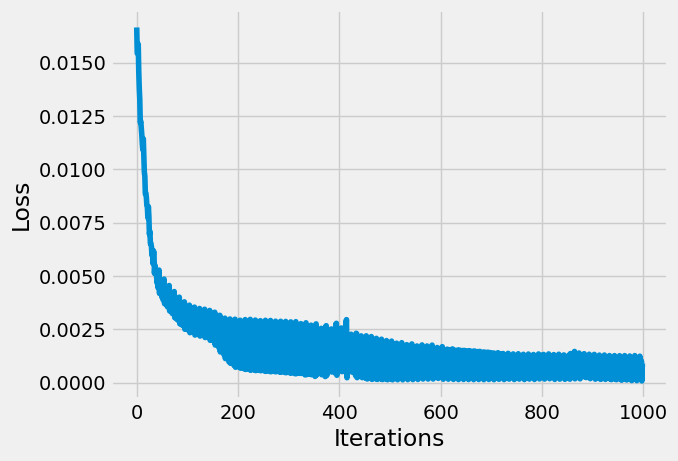

In [12]:

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot([elem.detach().numpy() for elem in losses[:]])
plt.show()

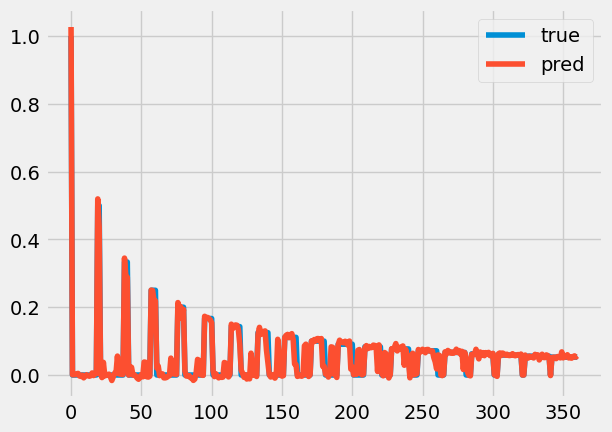

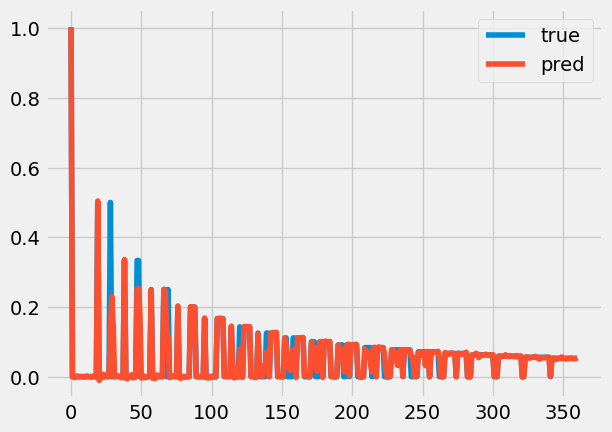

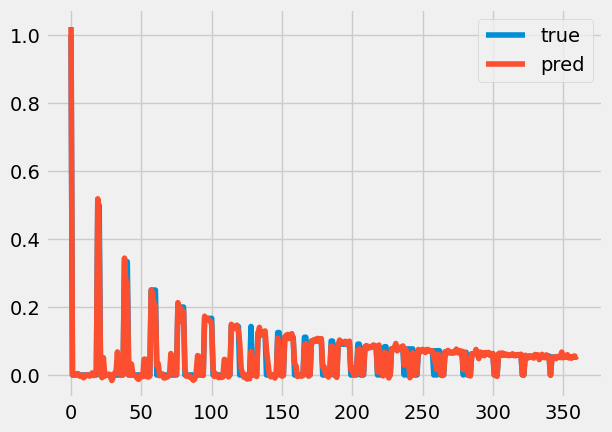

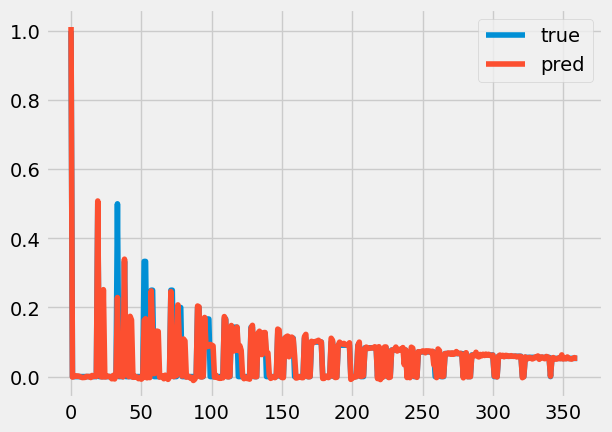

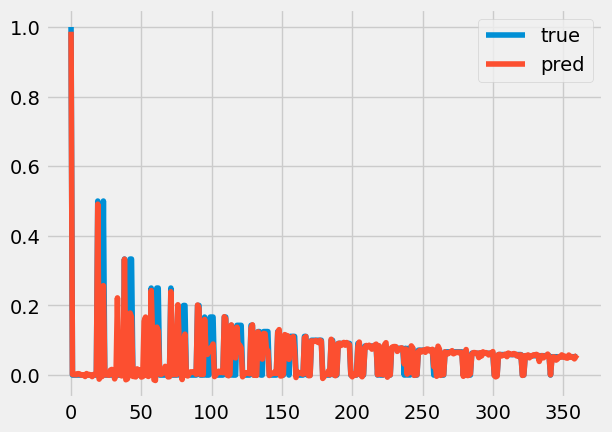

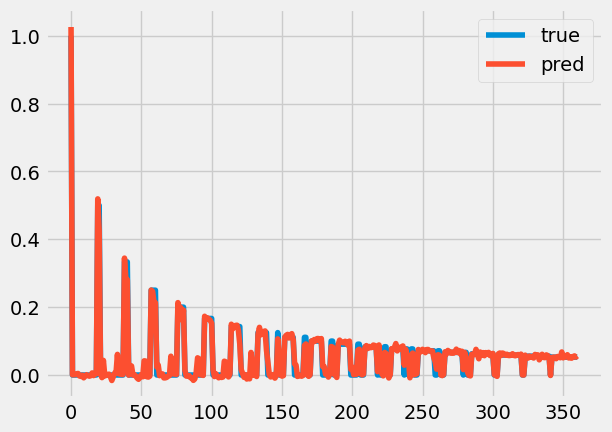

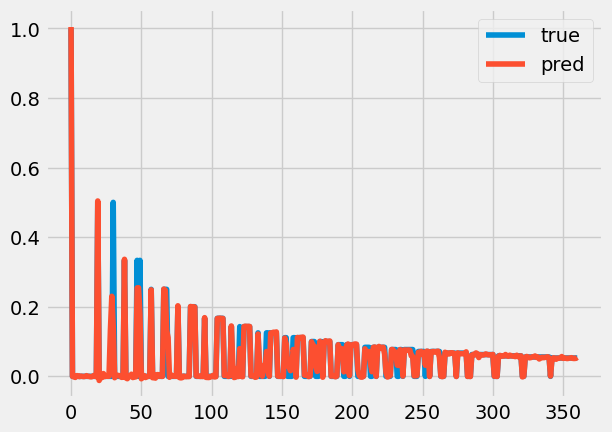

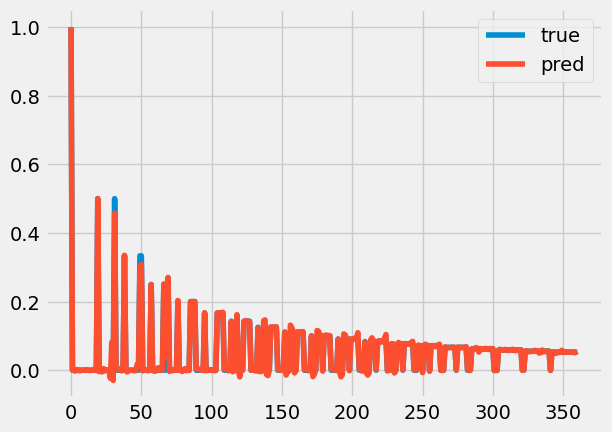

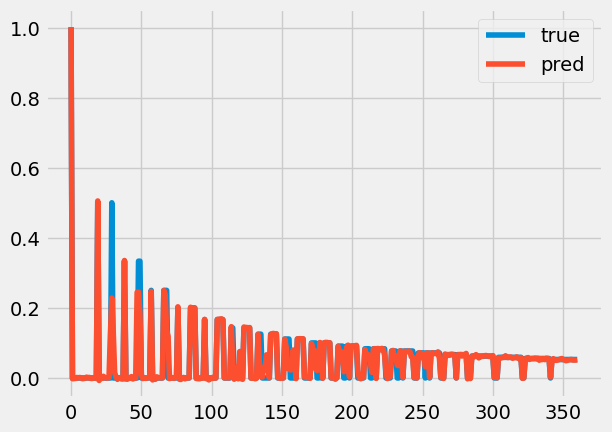

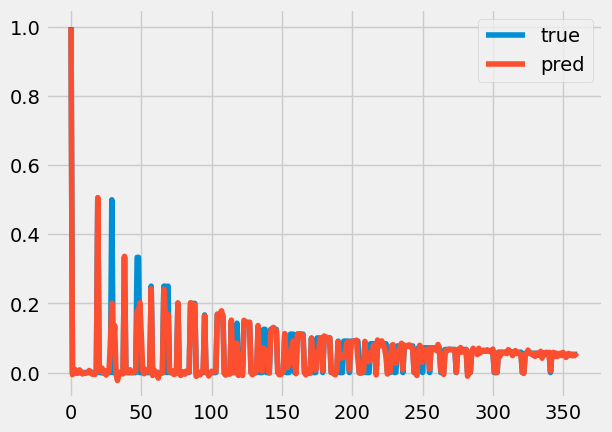

In [13]:
outputs = []
for human_id in range(10):
    for i in [1]:
        first_traj = human_to_trial_num_to_traj[human_id][i]

        first_traj = Variable(torch.Tensor(first_traj)).to(device=DEVICE)

        reconstructed = model(first_traj)

    #     print("reconstructed=", reconstructed)
    #     print("second_traj = ",second_traj)

        true = np.squeeze(np.squeeze(first_traj.detach().numpy(), 0), 0)
        pred = np.squeeze(np.squeeze(reconstructed.detach().numpy(), 0), 0)
        outputs.append(pred)

        plt.plot(range(len(true)), true)
        plt.plot(range(len(pred)), pred)
        plt.legend(['true', 'pred'])
        plt.show()
        plt.close()
    

In [14]:
# model.encoder(second_traj)

x_vals = []
y_vals = []
for human_id in human_to_trial_num_to_traj:
    print("human_id = ", human_id)
    for i in [1]:
        print("i = ", i)
        first_traj = human_to_trial_num_to_traj[human_id][i]


        first_traj = Variable(torch.Tensor(first_traj)).to(device=DEVICE)
#         second_traj = Variable(torch.Tensor(second_traj)).to(device=DEVICE)

    #     reconstructed = model(first_traj)
        latent_rep = model.encoder(first_traj)

    #     print("reconstructed=", reconstructed)
    #     print("second_traj = ",second_traj)

    #     true = np.squeeze(np.squeeze(second_traj.detach().numpy(), 0), 0)
        pred = np.squeeze(np.squeeze(latent_rep.detach().numpy(), 0), 0)
        print("pred = ", pred)

        x_vals.append(pred[0])
        y_vals.append(pred[1])
    

human_id =  0
i =  1
pred =  [-0.6911287 -2.7940829]
human_id =  1
i =  1
pred =  [-0.00602471 -0.17556521]
human_id =  2
i =  1
pred =  [-0.66452146 -2.693125  ]
human_id =  3
i =  1
pred =  [-0.3415986 -1.3155314]
human_id =  4
i =  1
pred =  [-0.27140355 -1.0055386 ]
human_id =  5
i =  1
pred =  [-0.6789881 -2.7527177]
human_id =  6
i =  1
pred =  [-0.00730697 -0.18625411]
human_id =  7
i =  1
pred =  [0.1630395 0.5896888]
human_id =  8
i =  1
pred =  [ 0.00217233 -0.13450125]
human_id =  9
i =  1
pred =  [0.05045917 0.10179988]
human_id =  10
i =  1
pred =  [-0.6054299 -2.4373434]
human_id =  11
i =  1
pred =  [0.1337162 0.5250852]
human_id =  12
i =  1
pred =  [ 0.02765616 -0.0093597 ]
human_id =  13
i =  1
pred =  [0.15171999 0.56576157]
human_id =  14
i =  1
pred =  [0.11928708 0.44450584]
human_id =  15
i =  1
pred =  [ 0.02518029 -0.01734173]
human_id =  16
i =  1
pred =  [-0.29041764 -1.0774999 ]
human_id =  17
i =  1
pred =  [0.07352934 0.20778868]
human_id =  18
i =  1
pred

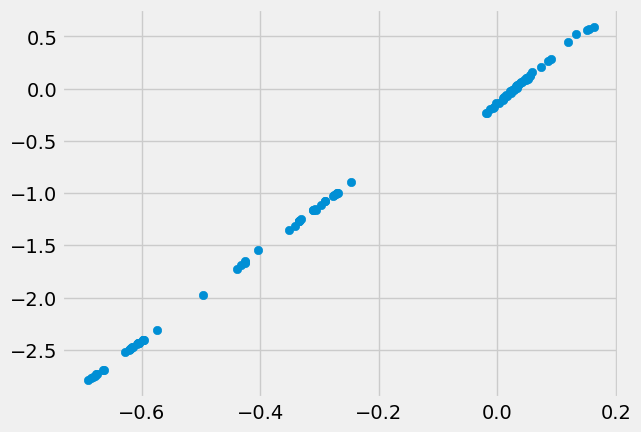

In [15]:
plt.scatter(x_vals, y_vals)
plt.show()

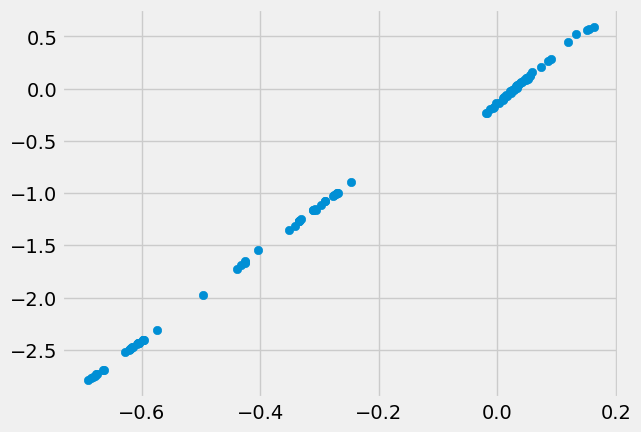

In [16]:
plt.scatter(x_vals, y_vals)
plt.show()

In [17]:
X = np.array([[x_vals[i], y_vals[i]] for i in range(len(x_vals))])

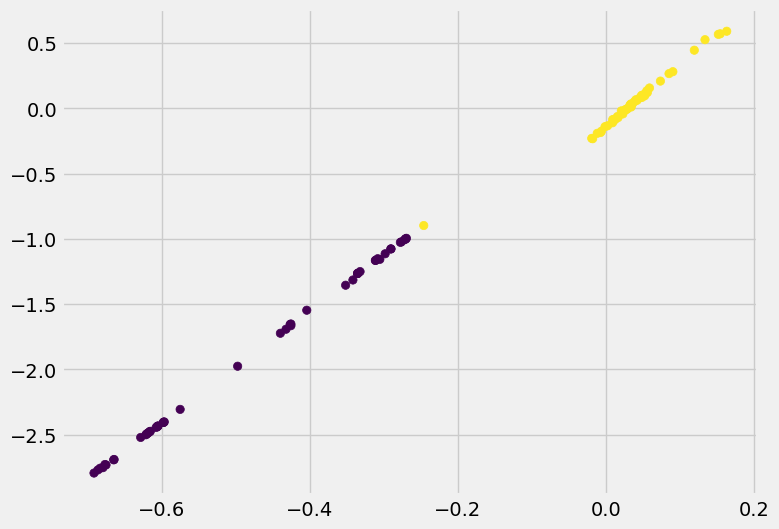

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling the data to normalize
model = KMeans(n_clusters=2).fit(X)

# Visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))
plt.show()

In [19]:
print("CLass 1 = ", np.count_nonzero(model.labels_))
print("CLass 2 = ", len(model.labels_) - np.count_nonzero(model.labels_))

CLass 1 =  49
CLass 2 =  51


In [20]:
len(human_to_trial_num_to_traj)

100

In [21]:
len(model.labels_)

100

In [22]:
labels = model.labels_.reshape((100))

In [23]:
label_to_text ={0: 'salad-then-dressing', 1:'dressing-then-salad'}

In [24]:
for i in range(len(labels)):
    print(f"id: {i}, label = {labels[i]}, {label_to_text[labels[i]]}")

id: 0, label = 0, salad-then-dressing
id: 1, label = 1, dressing-then-salad
id: 2, label = 0, salad-then-dressing
id: 3, label = 0, salad-then-dressing
id: 4, label = 0, salad-then-dressing
id: 5, label = 0, salad-then-dressing
id: 6, label = 1, dressing-then-salad
id: 7, label = 1, dressing-then-salad
id: 8, label = 1, dressing-then-salad
id: 9, label = 1, dressing-then-salad
id: 10, label = 0, salad-then-dressing
id: 11, label = 1, dressing-then-salad
id: 12, label = 1, dressing-then-salad
id: 13, label = 1, dressing-then-salad
id: 14, label = 1, dressing-then-salad
id: 15, label = 1, dressing-then-salad
id: 16, label = 0, salad-then-dressing
id: 17, label = 1, dressing-then-salad
id: 18, label = 0, salad-then-dressing
id: 19, label = 1, dressing-then-salad
id: 20, label = 1, dressing-then-salad
id: 21, label = 0, salad-then-dressing
id: 22, label = 1, dressing-then-salad
id: 23, label = 1, dressing-then-salad
id: 24, label = 0, salad-then-dressing
id: 25, label = 0, salad-then-dress

# Silhouette Score Analysis

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [26]:
X = np.array([[x_vals[i], y_vals[i]] for i in range(len(x_vals))])
sil_scores = []
n_cluster_list = []
for num_cluster in range(2, 10):
    model = KMeans(n_clusters=num_cluster).fit(X)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_scores.append(silhouette_avg)
    n_cluster_list.append(num_cluster)
    

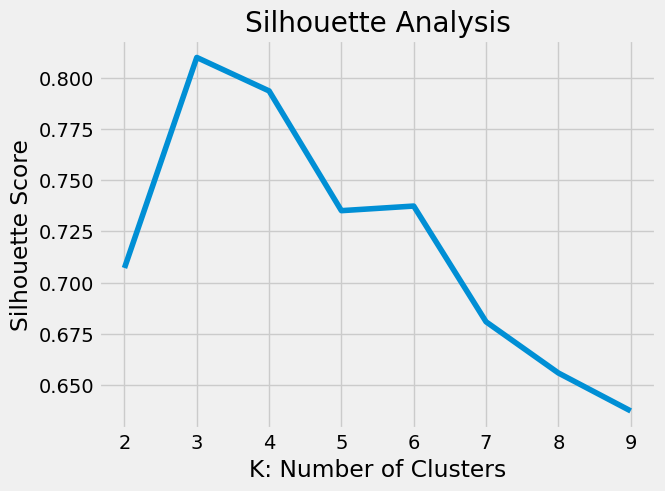

In [27]:
plt.plot(n_cluster_list, sil_scores)
plt.xlabel("K: Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

# Examine K=3

In [77]:
num_to_color = {0:'red', 1:'blue', 2:'green'}


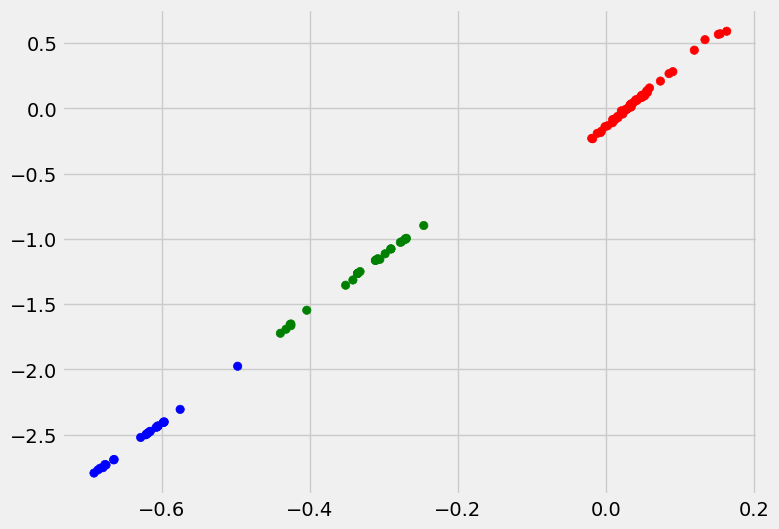

In [78]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling the data to normalize
K = 3
model = KMeans(n_clusters=K).fit(X)

# Visualize it:
plt.figure(figsize=(8, 6))
color_list = [num_to_color[c] for c in model.labels_.astype(float)]
# plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))
plt.scatter(X[:,0], X[:,1], c=color_list)
plt.show()

In [79]:
print("CLass 1 = ", list(model.labels_).count(0))
print("CLass 2 = ", list(model.labels_).count(1))
print("CLass 3 = ", list(model.labels_).count(2))

CLass 1 =  48
CLass 2 =  26
CLass 3 =  26


In [80]:
labels = model.labels_.reshape((100))

In [81]:
label_to_text ={1: 'salad-then-dressing', 0:'dressing-then-salad', 2:'idk'}

In [82]:
for i in range(len(labels)):
    print(f"id: {i}, label = {labels[i]}, {label_to_text[labels[i]]}")

id: 0, label = 1, salad-then-dressing
id: 1, label = 0, dressing-then-salad
id: 2, label = 1, salad-then-dressing
id: 3, label = 2, idk
id: 4, label = 2, idk
id: 5, label = 1, salad-then-dressing
id: 6, label = 0, dressing-then-salad
id: 7, label = 0, dressing-then-salad
id: 8, label = 0, dressing-then-salad
id: 9, label = 0, dressing-then-salad
id: 10, label = 1, salad-then-dressing
id: 11, label = 0, dressing-then-salad
id: 12, label = 0, dressing-then-salad
id: 13, label = 0, dressing-then-salad
id: 14, label = 0, dressing-then-salad
id: 15, label = 0, dressing-then-salad
id: 16, label = 2, idk
id: 17, label = 0, dressing-then-salad
id: 18, label = 1, salad-then-dressing
id: 19, label = 0, dressing-then-salad
id: 20, label = 0, dressing-then-salad
id: 21, label = 1, salad-then-dressing
id: 22, label = 0, dressing-then-salad
id: 23, label = 0, dressing-then-salad
id: 24, label = 1, salad-then-dressing
id: 25, label = 1, salad-then-dressing
id: 26, label = 0, dressing-then-salad
id: 2

# Train Aggregate Predictor

In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable 

In [158]:
stepsize = 6
train_percent = 0.8
check_index = None

In [159]:
trainX = []
trainY = []

for human_id in range(int(100*train_percent)):
    trial_id  = 1
    
    if check_index is not None and labels[human_id] != check_index:
        continue

    

    current_state = np.zeros(number_of_annots)
    seq = human_to_trial_num_to_sequence[human_id][trial_id]

    for i in range(len(seq)-stepsize):
        moving_window_x = []
        moving_window_y = []
        
        for j in range(stepsize):
            annot_idx = annot_to_num[seq[i+j]]
#             current_state[annot_idx] = current_state[annot_idx] + 1
            current_state = np.zeros(number_of_annots) # comment out for state
            
            current_state[annot_idx] = 1

#             normalized_current_state = [elem/sum(current_state) for elem in current_state]
        
            normalized_current_state = [elem/sum(current_state) for elem in current_state]

#             print("normalized_current_state", normalized_current_state)
            moving_window_x.extend(normalized_current_state)
            
        annot_idx = annot_to_num[seq[i+stepsize]]
#         current_state[annot_idx] = current_state[annot_idx] + 1
        current_state[annot_idx] = 1
        
        normalized_current_state = [elem/sum(current_state) for elem in current_state]
#         normalized_current_state = [elem for elem in current_state]
#         moving_window_y.extend(normalized_current_state)
        moving_window_y.append(annot_idx)

        trainX.append(moving_window_x)
        trainY.append(moving_window_y)

    
trainX = np.array(trainX)
trainY = np.array(trainY)

In [160]:
trainX.shape

(1040, 114)

In [161]:
trainY = np.squeeze(trainY,1)
trainY.shape

(1040,)

In [162]:
X_train_tensors = Variable(torch.Tensor(trainX))

y_train_tensors = Variable(torch.Tensor(trainY))


In [163]:
X_train_tensors.shape

torch.Size([1040, 114])

In [164]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [165]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 =  nn.Linear(128, 64) #fully connected 1
#         self.fc_3 =  nn.Linear(256, 64) #fully connected 1
        self.fc = nn.Linear(64, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#         out = self.relu(hn)
        out = self.fc_1(hn) #first Dense
#         out = self.relu(out) #relu
        out = self.fc_2(out) #first Dense
#         out = self.fc_3(out) #first Dense
        out = self.fc(out) #Final Output
        out = self.softmax(out)
        return out

In [166]:

num_epochs = 40000 #1000 epochs
learning_rate = 0.0001 #0.001 lr


input_size = 114 #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 19 #number of output classes 

In [167]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 


In [168]:
# criterion = torch.nn.MSELoss()    # mean-squared error for regression
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [169]:
losses = []
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
#     print("outputs", outputs)
#     print("y_train_tensors", y_train_tensors)
    loss = criterion(outputs, y_train_tensors.long())
    losses.append(loss.detach().numpy())

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 2.94445
Epoch: 1000, loss: 2.63387
Epoch: 2000, loss: 2.53927
Epoch: 3000, loss: 2.53140
Epoch: 4000, loss: 2.48516
Epoch: 5000, loss: 2.39467
Epoch: 6000, loss: 2.38913
Epoch: 7000, loss: 2.34476
Epoch: 8000, loss: 2.34031
Epoch: 9000, loss: 2.34001
Epoch: 10000, loss: 2.33950
Epoch: 11000, loss: 2.33739
Epoch: 12000, loss: 2.33720
Epoch: 13000, loss: 2.33707
Epoch: 14000, loss: 2.33502
Epoch: 15000, loss: 2.31497
Epoch: 16000, loss: 2.31478
Epoch: 17000, loss: 2.31266
Epoch: 18000, loss: 2.31259
Epoch: 19000, loss: 2.30530
Epoch: 20000, loss: 2.28842
Epoch: 21000, loss: 2.28715
Epoch: 22000, loss: 2.28710
Epoch: 23000, loss: 2.28705
Epoch: 24000, loss: 2.28609
Epoch: 25000, loss: 2.28506
Epoch: 26000, loss: 2.28494
Epoch: 27000, loss: 2.28490
Epoch: 28000, loss: 2.27453
Epoch: 29000, loss: 2.26792
Epoch: 30000, loss: 2.26790
Epoch: 31000, loss: 2.26694
Epoch: 32000, loss: 2.26692
Epoch: 33000, loss: 2.26691
Epoch: 34000, loss: 2.26690
Epoch: 35000, loss: 2.26689
Epoch

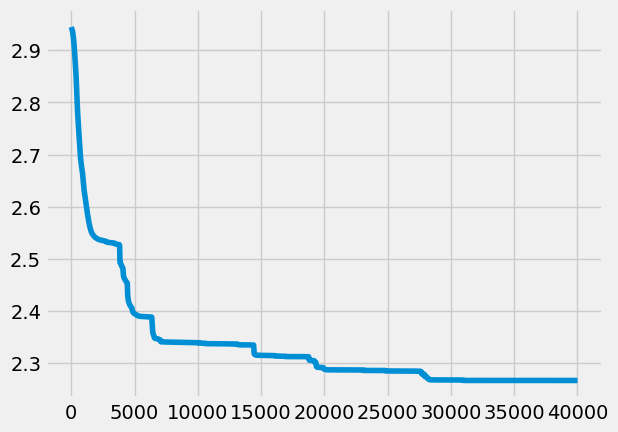

In [170]:
plt.plot(range(len(losses)), losses)
plt.show()

# Evaluate

In [171]:

count_correct = 0
total = 0
count_close = 0
train_true_list, train_pred_list = [], []

for human_id in range(int(100*train_percent)):
    trial_id  = 1
    
    if check_index is not None and labels[human_id] != check_index:
        continue
    
    current_state = np.zeros(number_of_annots)
    seq = human_to_trial_num_to_sequence[human_id][trial_id]

    for i in range(len(seq)-stepsize):
        human_id_trainX = []
        human_id_trainY = []

    
        moving_window_x = []
        moving_window_y = []
        
        
        for j in range(stepsize):
            annot_idx = annot_to_num[seq[i+j]]
#             current_state[annot_idx] = current_state[annot_idx] + 1

            current_state = np.zeros(number_of_annots)
            current_state[annot_idx] = 1

            normalized_current_state = [elem/sum(current_state) for elem in current_state]

#             print("normalized_current_state", normalized_current_state)
            moving_window_x.extend(normalized_current_state)
            
        annot_idx = annot_to_num[seq[i+stepsize]]
#         current_state[annot_idx] = current_state[annot_idx] + 1
        current_state[annot_idx] = 1
        normalized_current_state = [elem for elem in current_state]
#         normalized_current_state = [elem for elem in current_state]
        moving_window_y.append(annot_idx)

        human_id_trainX.append(moving_window_x)
        human_id_trainY.append(moving_window_y)

    
        human_id_trainX = np.array(human_id_trainX)
        human_id_trainY = np.array(human_id_trainY)

        X_train_tensors = Variable(torch.Tensor(human_id_trainX))
        y_train_tensors = Variable(torch.Tensor(human_id_trainY))
        

        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


#         print("X_train_tensors_final", X_train_tensors_final)
        outputs = lstm1.forward(X_train_tensors_final)
        outputs = outputs.detach().numpy()[0]
        pred_idx = np.argmax(outputs)
        true_idx = int(y_train_tensors.detach().numpy()[0][0])
        
        train_true_list.append(true_idx)
        train_pred_list.append(pred_idx)
        
        outputs_max = np.max(outputs)
        true_idx_val = outputs[true_idx]
        
        if abs(outputs_max - true_idx_val) < 0.1:
            count_close += 1
#         outputs = [np.round(elem,2) if abs(elem) > 0.05 else 0 for elem in outputs]
#         num_nonzero = np.count_nonzero(outputs)
#         outputs = [np.round(elem*num_nonzero,0) if abs(elem) > 0.05 else 0 for elem in outputs]
#         print("num_nonzero", num_nonzero)
#         print("pred_idx", pred_idx)
#         print("true_idx", true_idx)
#         print(outputs == y_train_tensors.detach().numpy()[0])
        if (pred_idx == true_idx):
            count_correct += 1
        total += 1
#         break
#     break
        
print("train accuracy =", count_correct/total)
print("close but not quite: train accuracy =", count_close/total)


train accuracy = 0.7615384615384615
close but not quite: train accuracy = 0.7721153846153846


In [172]:

count_correct = 0
total = 0
count_close = 0
test_true_list = []
test_pred_list = []

for human_id in range(int(100*train_percent), 100):
#     print(f"human_id: {human_id}")
    trial_id  = 1

    if check_index is not None and labels[human_id] != check_index:
        continue
    
    current_state = np.zeros(number_of_annots)
    seq = human_to_trial_num_to_sequence[human_id][trial_id]

    for i in range(len(seq)-stepsize):
        human_id_trainX = []
        human_id_trainY = []

    
        moving_window_x = []
        moving_window_y = []
        
        moving_window_x_annot_text = []
        moving_window_y_annot_text = []
        
        
        for j in range(stepsize):
            annot_idx = annot_to_num[seq[i+j]]
#             current_state[annot_idx] = current_state[annot_idx] + 1
            current_state = np.zeros(number_of_annots)
    
            current_state[annot_idx] = 1
            
            normalized_current_state = [elem/sum(current_state) for elem in current_state]

#             print("normalized_current_state", normalized_current_state)
            moving_window_x.extend(normalized_current_state)
            moving_window_x_annot_text.append(annot_idx)
            
        annot_idx = annot_to_num[seq[i+stepsize]]
        moving_window_y_annot_text.append(annot_idx)
#         current_state[annot_idx] = current_state[annot_idx] + 1
        current_state[annot_idx] = 1
        normalized_current_state = [elem for elem in current_state]
#         normalized_current_state = [elem for elem in current_state]
        moving_window_y.append(annot_idx)

        human_id_trainX.append(moving_window_x)
        human_id_trainY.append(moving_window_y)

    
        human_id_trainX = np.array(human_id_trainX)
        human_id_trainY = np.array(human_id_trainY)

        
        X_train_tensors = Variable(torch.Tensor(human_id_trainX))
        y_train_tensors = Variable(torch.Tensor(human_id_trainY))
#         print("Input X:", [num_to_annot[c] for c in moving_window_x_annot_text])
        
        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


#         print("X_train_tensors_final", X_train_tensors_final)
        outputs = lstm1.forward(X_train_tensors_final)
        outputs = outputs.detach().numpy()[0]
        
        pred_idx = np.argmax(outputs)
        true_idx = int(y_train_tensors.detach().numpy()[0][0])
        
#         print(f"True Y: {true_idx}, {num_to_annot[true_idx]}, {outputs[true_idx]}" )
#         print(f"Pred Y: {pred_idx}, {num_to_annot[pred_idx]}, {outputs[pred_idx]}" )
        
#         print()
        
        test_true_list.append(true_idx)
        test_pred_list.append(pred_idx)
        
        outputs_max = np.max(outputs)
        true_idx_val = outputs[true_idx]
        
        if abs(outputs_max - true_idx_val) < 0.1:
            count_close += 1
#         outputs = [np.round(elem,2) if abs(elem) > 0.05 else 0 for elem in outputs]
#         num_nonzero = np.count_nonzero(outputs)
#         outputs = [np.round(elem*num_nonzero,0) if abs(elem) > 0.05 else 0 for elem in outputs]
#         print("num_nonzero", num_nonzero)
#         print("pred_idx", pred_idx)
#         print("true_idx", true_idx)
#         print(outputs == y_train_tensors.detach().numpy()[0])
        if (pred_idx == true_idx):
            count_correct += 1
        total += 1
#         break
#     break
        
print("test accuracy =", count_correct/total)
print("close but not quite: test accuracy =", count_close/total)


test accuracy = 0.676923076923077
close but not quite: train accuracy = 0.6846153846153846


# Confusion Matrix

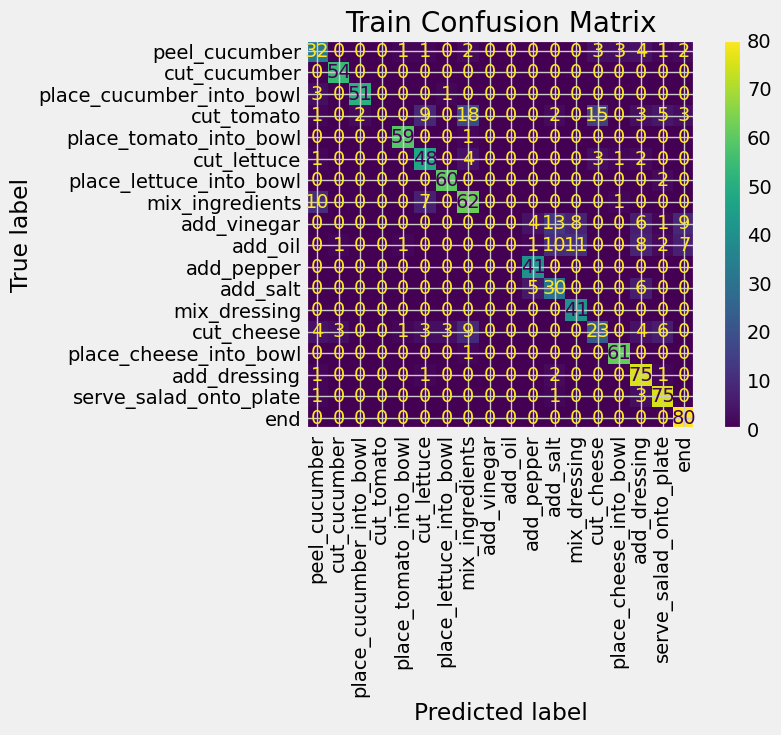

In [173]:
confusion_matrix = metrics.confusion_matrix(train_true_list, train_pred_list)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(train_true_list, train_pred_list, 
                                                             display_labels = [num_to_annot[x] for x in set(train_true_list+train_pred_list)],
                                                           xticks_rotation='vertical')

# cm_display.plot()
plt.title("Train Confusion Matrix")
plt.show()

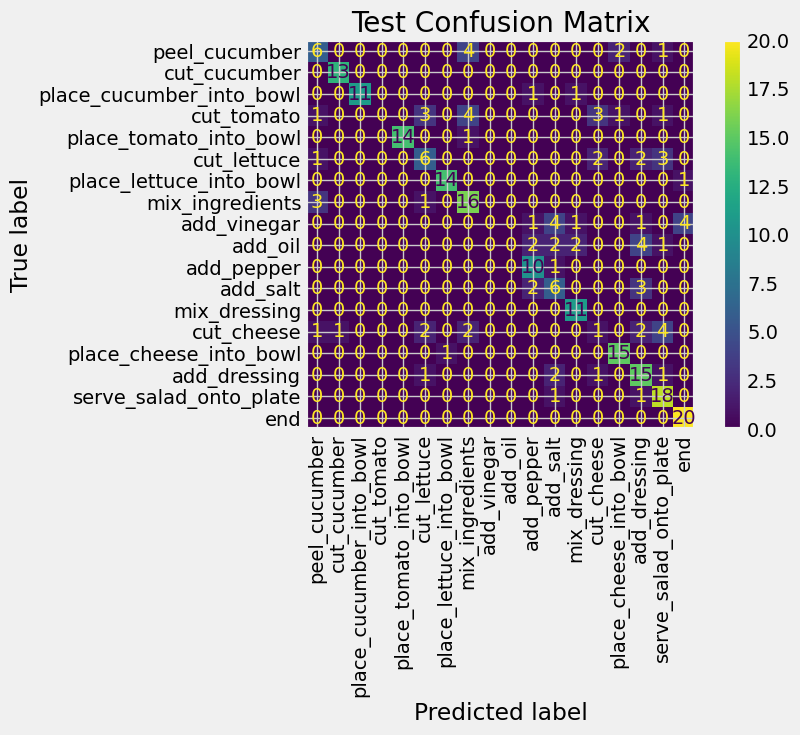

In [174]:
confusion_matrix = metrics.confusion_matrix(test_true_list, test_pred_list)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_true_list, test_pred_list, 
                                                             display_labels = [num_to_annot[x] for x in set(test_true_list+test_pred_list)],
                                                           xticks_rotation='vertical')

# cm_display.plot()
plt.title("Test Confusion Matrix")
plt.show()